<a href="https://colab.research.google.com/github/Chia-Tien-Tang/Deep-Learning-in-Practice_Assignment/blob/main/TP3/TP3_GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical Session on Graph Neural Networks

**by Matthieu Nastorg and Cyriaque Rousselot**

## **PART 1 : CODING** (8/20)

### Install Pytorch Geometric

To handle graph data, we use the library Pytorch Geometric : https://pytorch-geometric.readthedocs.io/en/latest/

*   If you use _Google Colab_, simply run the following cell to install Pytorch Geometric (**advised**).
*   If you plan using your _own environment_, follow the documentation to install Pytorch Geometric : https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html and skip the following cell.

In [1]:
########## INSTALL TORCH GEOMETRIC ##################
# https://pytorch-geometric.readthedocs.io/en/latest/
#####################################################
import torch


def format_pytorch_version(version):
    return version.split("+")[0]


TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)


def format_cuda_version(version):
    return "cu" + version.replace(".", "")


CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 40.2 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 14.7 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 43.0 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 932.1/932.1 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.0 MB/s eta 0:00:00


### Import required packages

Run the following cell to import all required packages. This cell **must not** be modified.

To significantly accelerate your training, it is advised to use GPU. Using Google Colab, you need to activate it :

*   Edit --> Notebook Setting --> Hardware accelerator --> GPU

In [2]:
#####################################################
################## PACKAGES #########################
#####################################################
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch_geometric.nn as graphnn
from sklearn.metrics import f1_score
from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader

### Dataset

We use the Protein-Protein Interaction (PPI) network dataset which includes:
- 20 graphs for training
- 2 graphs for validation
- 2 graphs for testing

One graph of the PPI dataset has on average 2372 nodes. Each node:
- 50 features : positional gene sets / motif gene / immunological signatures ...
- 121 (binary) labels : gene ontology sets (way to classify gene products like proteins).

**This problem aims to predict, for a given PPI graph, the correct node's labels**.

**It is a node (multi-level) classification task** (trained using supervised learning).

For your curiosity, more details information on the dataset and some applications:
- https://cs.stanford.edu/~jure/pubs/pathways-psb18.pdf
- https://arxiv.org/abs/1707.04638

To understand how a graph data is implemented in Pytorch Geometric, refer to : https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html


In [3]:
### LOAD DATASETS

BATCH_SIZE = 2

# Train Dataset
train_dataset = PPI(root="", split="train")
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
# Val Dataset
val_dataset = PPI(root="", split="val")
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
# Test Dataset
test_dataset = PPI(root="", split="test")
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Number of features and classes
n_features, n_classes = train_dataset[0].x.shape[1], train_dataset[0].y.shape[1]

print("Number of samples in the train dataset: ", len(train_dataset))
print("Number of samples in the val dataset: ", len(test_dataset))
print("Number of samples in the test dataset: ", len(test_dataset))
print("Output of one sample from the train dataset: ", train_dataset[0])
print("Edge_index :")
print(train_dataset[0].edge_index)
print("Number of features per node: ", n_features)
print("Number of classes per node: ", n_classes)

Extracting ./ppi.zip
Processing...


Number of samples in the train dataset:  20
Number of samples in the val dataset:  2
Number of samples in the test dataset:  2
Output of one sample from the train dataset:  Data(x=[1767, 50], edge_index=[2, 32318], y=[1767, 121])
Edge_index :
tensor([[   0,    0,    0,  ..., 1744, 1745, 1749],
        [ 372, 1101,  766,  ..., 1745, 1744, 1739]])
Number of features per node:  50
Number of classes per node:  121


Done!


### Define a basic Model

Here we define a very simple Graph Neural Network model which will be used as our baseline. This model consists of three graph convolutional layers (from https://arxiv.org/pdf/1609.02907.pdf). The first two layers computes 256 features, followed by an ELU activation function. The last layer is used for (multi-level) classification task, computing 121 features.

In [15]:
#####################################################
################## MODEL ############################
#####################################################
class BasicGraphModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.graphconv1 = graphnn.GCNConv(input_size, hidden_size)
        self.graphconv2 = graphnn.GCNConv(hidden_size, hidden_size)
        self.graphconv3 = graphnn.GCNConv(hidden_size, output_size)

        self.elu = nn.ELU()

    def forward(self, x, edge_index):
        x = self.graphconv1(x, edge_index)
        x = self.elu(x)
        x = self.graphconv2(x, edge_index)
        x = self.elu(x)
        x = self.graphconv3(x, edge_index)

        return x

Next we construct the function to train the model.

In [16]:
#####################################################
############## TRAIN FUNCTION #######################
#####################################################
def train(
    model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader
):

    epoch_list = []
    scores_list = []

    # loop over epochs
    for epoch in range(max_epochs):
        model.train()
        losses = []
        # loop over batches
        for i, train_batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            train_batch_device = train_batch.to(device)
            # logits is the output of the model
            logits = model(train_batch_device.x, train_batch_device.edge_index)
            # compute the loss
            loss = loss_fcn(logits, train_batch_device.y)
            # optimizer step
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        loss_data = np.array(losses).mean()
        print("Epoch {:05d} | Loss: {:.4f}".format(epoch + 1, loss_data))

        if epoch % 5 == 0:
            # evaluate the model on the validation set
            # computes the f1-score (see next function)
            score = evaluate(model, loss_fcn, device, val_dataloader)
            print("F1-Score: {:.4f}".format(score))
            scores_list.append(score)
            epoch_list.append(epoch)

    return epoch_list, scores_list

Next function is designed to evaluate the performance of the model, computing the F1-Score

In [17]:
#####################################################
############### TEST FUNCTION #######################
#####################################################
def evaluate(model, loss_fcn, device, dataloader):
    score_list_batch = []

    model.eval()
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        output = model(batch.x, batch.edge_index)
        loss_test = loss_fcn(output, batch.y)
        predict = np.where(output.detach().cpu().numpy() >= 0, 1, 0)
        score = f1_score(batch.y.cpu().numpy(), predict, average="micro")
        score_list_batch.append(score)

    return np.array(score_list_batch).mean()

Let's train this model !

In [18]:
### DEVICE GPU OR CPU : will select GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nDevice: ", device)

### Max number of epochs
max_epochs = 200

### DEFINE THE MODEL
basic_model = BasicGraphModel(
    input_size=n_features, hidden_size=256, output_size=n_classes
).to(device)

### DEFINE LOSS FUNCTION
loss_fcn = nn.BCEWithLogitsLoss()

### DEFINE OPTIMIZER
optimizer = torch.optim.Adam(basic_model.parameters(), lr=0.005)

### TRAIN THE MODEL
epoch_list, basic_model_scores = train(
    basic_model,
    loss_fcn,
    device,
    optimizer,
    max_epochs,
    train_dataloader,
    val_dataloader,
)


Device:  cuda
Epoch 00001 | Loss: 0.6368
F1-Score: 0.4504
Epoch 00002 | Loss: 0.5804
Epoch 00003 | Loss: 0.5624
Epoch 00004 | Loss: 0.5554
Epoch 00005 | Loss: 0.5505
Epoch 00006 | Loss: 0.5458
F1-Score: 0.5026
Epoch 00007 | Loss: 0.5418
Epoch 00008 | Loss: 0.5378
Epoch 00009 | Loss: 0.5341
Epoch 00010 | Loss: 0.5311
Epoch 00011 | Loss: 0.5284
F1-Score: 0.5189
Epoch 00012 | Loss: 0.5258
Epoch 00013 | Loss: 0.5233
Epoch 00014 | Loss: 0.5209
Epoch 00015 | Loss: 0.5185
Epoch 00016 | Loss: 0.5162
F1-Score: 0.5332
Epoch 00017 | Loss: 0.5139
Epoch 00018 | Loss: 0.5117
Epoch 00019 | Loss: 0.5095
Epoch 00020 | Loss: 0.5073
Epoch 00021 | Loss: 0.5052
F1-Score: 0.5408
Epoch 00022 | Loss: 0.5031
Epoch 00023 | Loss: 0.5011
Epoch 00024 | Loss: 0.4992
Epoch 00025 | Loss: 0.4972
Epoch 00026 | Loss: 0.4953
F1-Score: 0.5504
Epoch 00027 | Loss: 0.4934
Epoch 00028 | Loss: 0.4916
Epoch 00029 | Loss: 0.4897
Epoch 00030 | Loss: 0.4880
Epoch 00031 | Loss: 0.4864
F1-Score: 0.5570
Epoch 00032 | Loss: 0.4849
Ep

Let's evaluate the performance of this basic model

Basic Model : F1-Score on the test set: 0.6305


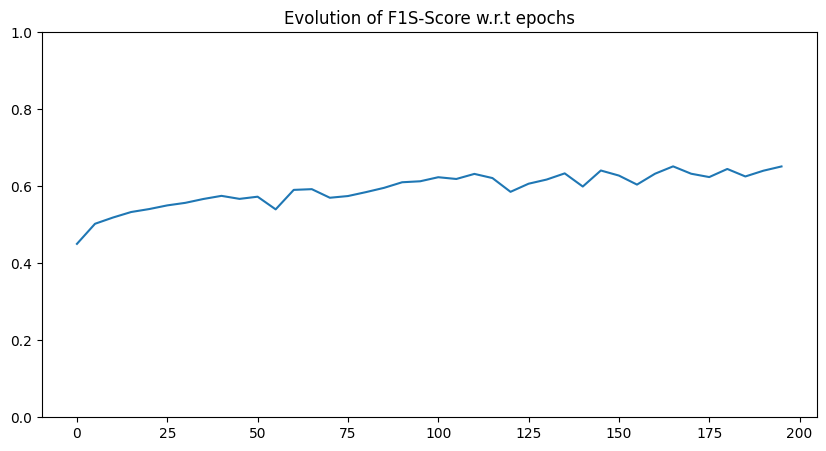

In [19]:
### F1-SCORE ON TEST DATASET
score_test = evaluate(basic_model, loss_fcn, device, test_dataloader)
print("Basic Model : F1-Score on the test set: {:.4f}".format(score_test))


### PLOT EVOLUTION OF F1-SCORE W.R.T EPOCHS
def plot_f1_score(epoch_list, scores):
    plt.figure(figsize=[10, 5])
    plt.plot(epoch_list, scores)
    plt.title("Evolution of F1S-Score w.r.t epochs")
    plt.ylim([0.0, 1.0])
    plt.show()


plot_f1_score(epoch_list, basic_model_scores)

### Define a better model

Now, it's your turn to improve this basic model ! To do so, complete whenever ###### YOUR ANSWER ######## and run the two following cells.

**HINT :** https://arxiv.org/pdf/1710.10903.pdf

#GAT Transductive Learning Model (Without using Sigmoid)

In [20]:
from torch_geometric.nn import GATConv

In [21]:
class StudentModel(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
      super().__init__()

      ####### YOUR ANSWER #######
       # GAT layers
      self.gatconv1 = graphnn.GATConv(input_size, hidden_size, heads=8, dropout=0.6)
      self.gatconv2 = graphnn.GATConv(8*hidden_size, hidden_size, heads=8, concat=False, dropout=0.6)

      # Linear layer for multi-label classification
      self.linear = nn.Linear(hidden_size, output_size)

      # Activation
      self.elu = nn.ELU()

  def forward(self, x, edge_index):

      ####### YOUR ANSWER #######
      x = self.gatconv1(x, edge_index)
      x = self.elu(x)
      x = self.gatconv2(x, edge_index)
      x = self.elu(x)
      x = self.linear(x)
      return x

Let's train your model !

In [22]:
## Student model
# student_model = StudentModel(##### YOUR ANSWER #####).to(device)
student_model = StudentModel(input_size=n_features, hidden_size=256, output_size=n_classes).to(device)

### DEFINE LOSS FUNCTION AND OPTIMIZER
optimizer = torch.optim.Adam(student_model.parameters(), lr=0.005)

### TRAIN
epoch_list, student_model_scores = train(student_model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader)

Epoch 00001 | Loss: 0.6090
F1-Score: 0.4151
Epoch 00002 | Loss: 0.5459
Epoch 00003 | Loss: 0.5355
Epoch 00004 | Loss: 0.5260
Epoch 00005 | Loss: 0.5209
Epoch 00006 | Loss: 0.5141
F1-Score: 0.4601
Epoch 00007 | Loss: 0.5090
Epoch 00008 | Loss: 0.5046
Epoch 00009 | Loss: 0.5053
Epoch 00010 | Loss: 0.5005
Epoch 00011 | Loss: 0.4965
F1-Score: 0.5180
Epoch 00012 | Loss: 0.4959
Epoch 00013 | Loss: 0.4909
Epoch 00014 | Loss: 0.4879
Epoch 00015 | Loss: 0.4868
Epoch 00016 | Loss: 0.4874
F1-Score: 0.5281
Epoch 00017 | Loss: 0.4833
Epoch 00018 | Loss: 0.4801
Epoch 00019 | Loss: 0.4765
Epoch 00020 | Loss: 0.4753
Epoch 00021 | Loss: 0.4727
F1-Score: 0.5660
Epoch 00022 | Loss: 0.4719
Epoch 00023 | Loss: 0.4692
Epoch 00024 | Loss: 0.4675
Epoch 00025 | Loss: 0.4690
Epoch 00026 | Loss: 0.4639
F1-Score: 0.5818
Epoch 00027 | Loss: 0.4609
Epoch 00028 | Loss: 0.4577
Epoch 00029 | Loss: 0.4572
Epoch 00030 | Loss: 0.4557
Epoch 00031 | Loss: 0.4573
F1-Score: 0.5812
Epoch 00032 | Loss: 0.4528
Epoch 00033 | Los

Let's evaluate the performance of your model

Student Model : F1-Score on the test set: 0.7205


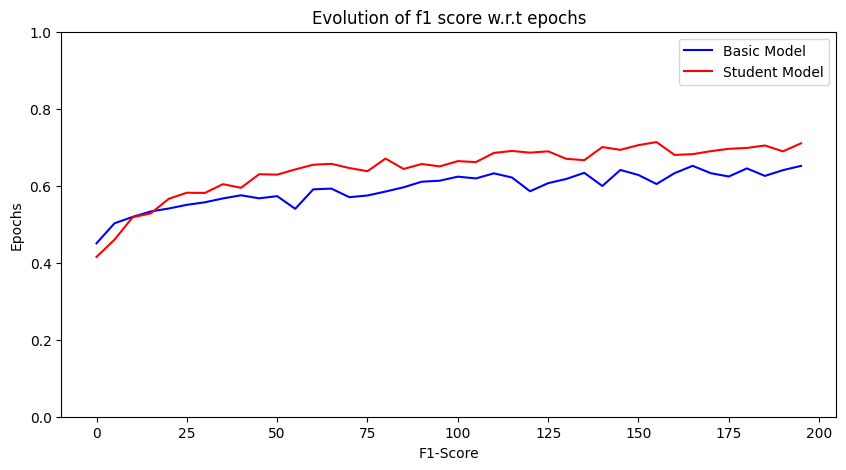

In [23]:
score_test = evaluate(student_model, loss_fcn, device, test_dataloader)
print("Student Model : F1-Score on the test set: {:.4f}".format(score_test))


def plot_f1_score(epoch_list, basic_model_scores, student_model_scores):
    plt.figure(figsize=[10, 5])
    plt.plot(epoch_list, basic_model_scores, "b", label="Basic Model")
    plt.plot(epoch_list, student_model_scores, "r", label="Student Model")
    plt.title("Evolution of f1 score w.r.t epochs")
    plt.ylim([0.0, 1.0])
    plt.ylabel("Epochs")
    plt.xlabel("F1-Score")
    plt.legend()
    plt.show()


plot_f1_score(epoch_list, basic_model_scores, student_model_scores)

#GAT Inductive Learning Model (Without using Sigmoid)

In [24]:
class StudentModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self._init_weights()

        # GAT layers
        self.gat1 = GATConv(input_size, hidden_size, heads=6, concat=True)
        self.gat2 = GATConv(hidden_size * 6, hidden_size, heads=6, concat=True)
        self.gat3 = GATConv(hidden_size * 6, output_size, heads=4, concat=False)

        # Activation
        self.elu = nn.ELU()

    def _init_weights(self):

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)

    def forward(self, x, edge_index):
        # First GAT layer
        x = self.elu(self.gat1(x, edge_index))
        x_skip = x.clone()
        # Second GAT layer
        x = self.elu(self.gat2(x, edge_index))
        # Third GAT layer for classification
        x = x + x_skip
        x = self.gat3(x, edge_index)
        return x

In [25]:
## Student model
# student_model = StudentModel(##### YOUR ANSWER #####).to(device)
student_model = StudentModel(input_size=n_features, hidden_size=256, output_size=n_classes).to(device)

### DEFINE LOSS FUNCTION AND OPTIMIZER
optimizer = torch.optim.Adam(student_model.parameters(), lr=0.005)

### TRAIN
epoch_list, student_model_scores = train(student_model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader)

Epoch 00001 | Loss: 0.8048
F1-Score: 0.4437
Epoch 00002 | Loss: 0.5630
Epoch 00003 | Loss: 0.5389
Epoch 00004 | Loss: 0.5211
Epoch 00005 | Loss: 0.5190
Epoch 00006 | Loss: 0.5109
F1-Score: 0.4924
Epoch 00007 | Loss: 0.4994
Epoch 00008 | Loss: 0.4914
Epoch 00009 | Loss: 0.4887
Epoch 00010 | Loss: 0.4884
Epoch 00011 | Loss: 0.4808
F1-Score: 0.5568
Epoch 00012 | Loss: 0.4717
Epoch 00013 | Loss: 0.4655
Epoch 00014 | Loss: 0.4628
Epoch 00015 | Loss: 0.4631
Epoch 00016 | Loss: 0.4509
F1-Score: 0.5971
Epoch 00017 | Loss: 0.4436
Epoch 00018 | Loss: 0.4374
Epoch 00019 | Loss: 0.4318
Epoch 00020 | Loss: 0.4302
Epoch 00021 | Loss: 0.4320
F1-Score: 0.6164
Epoch 00022 | Loss: 0.4255
Epoch 00023 | Loss: 0.4117
Epoch 00024 | Loss: 0.4026
Epoch 00025 | Loss: 0.3952
Epoch 00026 | Loss: 0.3912
F1-Score: 0.6638
Epoch 00027 | Loss: 0.3873
Epoch 00028 | Loss: 0.3807
Epoch 00029 | Loss: 0.3746
Epoch 00030 | Loss: 0.3725
Epoch 00031 | Loss: 0.3757
F1-Score: 0.6687
Epoch 00032 | Loss: 0.3908
Epoch 00033 | Los

Student Model : F1-Score on the test set: 0.9383


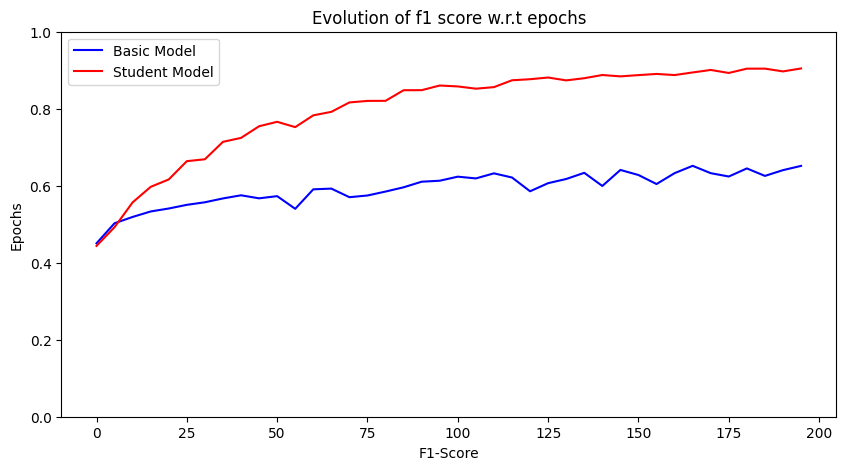

In [26]:
score_test = evaluate(student_model, loss_fcn, device, test_dataloader)
print("Student Model : F1-Score on the test set: {:.4f}".format(score_test))


def plot_f1_score(epoch_list, basic_model_scores, student_model_scores):
    plt.figure(figsize=[10, 5])
    plt.plot(epoch_list, basic_model_scores, "b", label="Basic Model")
    plt.plot(epoch_list, student_model_scores, "r", label="Student Model")
    plt.title("Evolution of f1 score w.r.t epochs")
    plt.ylim([0.0, 1.0])
    plt.ylabel("Epochs")
    plt.xlabel("F1-Score")
    plt.legend()
    plt.show()


plot_f1_score(epoch_list, basic_model_scores, student_model_scores)

**With Epoch 300**

In [27]:
## Student model
# student_model = StudentModel(##### YOUR ANSWER #####).to(device)
student_model = StudentModel(input_size=n_features, hidden_size=256, output_size=n_classes).to(device)

### DEFINE LOSS FUNCTION AND OPTIMIZER
optimizer = torch.optim.Adam(student_model.parameters(), lr=0.005)

### TRAIN
epoch_list, student_model_scores = train(student_model, loss_fcn, device, optimizer, 250, train_dataloader, val_dataloader)

Epoch 00001 | Loss: 0.7125
F1-Score: 0.4573
Epoch 00002 | Loss: 0.5620
Epoch 00003 | Loss: 0.5420
Epoch 00004 | Loss: 0.5336
Epoch 00005 | Loss: 0.5191
Epoch 00006 | Loss: 0.5103
F1-Score: 0.5345
Epoch 00007 | Loss: 0.5067
Epoch 00008 | Loss: 0.4998
Epoch 00009 | Loss: 0.4917
Epoch 00010 | Loss: 0.4845
Epoch 00011 | Loss: 0.4787
F1-Score: 0.5341
Epoch 00012 | Loss: 0.4716
Epoch 00013 | Loss: 0.4690
Epoch 00014 | Loss: 0.4590
Epoch 00015 | Loss: 0.4536
Epoch 00016 | Loss: 0.4471
F1-Score: 0.5900
Epoch 00017 | Loss: 0.4396
Epoch 00018 | Loss: 0.4440
Epoch 00019 | Loss: 0.4359
Epoch 00020 | Loss: 0.4258
Epoch 00021 | Loss: 0.4185
F1-Score: 0.6430
Epoch 00022 | Loss: 0.4169
Epoch 00023 | Loss: 0.4195
Epoch 00024 | Loss: 0.4111
Epoch 00025 | Loss: 0.4014
Epoch 00026 | Loss: 0.3932
F1-Score: 0.6717
Epoch 00027 | Loss: 0.3882
Epoch 00028 | Loss: 0.3902
Epoch 00029 | Loss: 0.3907
Epoch 00030 | Loss: 0.3818
Epoch 00031 | Loss: 0.3773
F1-Score: 0.6882
Epoch 00032 | Loss: 0.3715
Epoch 00033 | Los

In [ ]:
score_test = evaluate(student_model, loss_fcn, device, test_dataloader)
print("Student Model : F1-Score on the test set: {:.4f}".format(score_test))

Student Model : F1-Score on the test set: 0.9557


## **PART 2 : QUESTIONS** (12/20)

**1. Make a small paragraph that : (4pts)**
1. Explains your achitecture and justify your choices (why the Graph Layer you chose is more efficient than the GCNLayer from the Basic Model?).
2. Analyses your results (what is the F1-Score ? are your results convincing ? what is your position w.r.t state-of-the-art ?).

>Answer  

1. According to our observation and study of paper, we think that the main difference between GCN and GATs is how the node features are aggregated. Actually, in GCN layers, they apply the same weight to all neighbors of a node, however, GAT layers use self-attention mechanisms to weigh the different importance of each neighbor's features so that GATs model can be able to focus on more relevant features to learn more complex patterns from the data.
Architecture from paper starts with a GAT layer, which allows to expand the feature representation with using multi-head attention. Through this layer, the model can increase the its capacity by learning from different representation subspaces. The following GAT layers clarify these features. At the end, the final layer collapses the multi-head outputs to match the number of output features size.


[Key Factors]
- Skip Connections: Form of residual learning. It can help resolve the vanishing gradient problems and then make network more effectively by allowing gradients to flow, especially for deeper architectures (Like what we did from 200 epochs to 300 epochs).
- Initializtion of weights: We use Xavier initialization to prevent initial weights to be neither too small nor too large. And if we initial it correctly then we can guarantee that the model can learn more effectively and also have stable learning process and faster convergence.

Conclusion: PPI network dataset has relationships between proteins that can have various degrees of relevance. GATs model is more efficient than GCN because of its ability to capture the varying significance of different nodes within the graph more accurately.


2. The F1-Score for our GAT Inductive model on the PPI dataset is 0.9557 after 300 epochs (In the state-of-the-art, it uses only 200 epochs and achieves 0.973 ± 0.002). Although we have around 0.015 diffrence compared to the state-of-art, we still think that we already achieve a pretty good score on this compleicated task, "node classification in PPI networks". And also comopared to all the other listed state-of-art models, including GraphSAGE variants, our GAT model outperforms well. So in conclusion, we believe that our model is not only accurate but also generalizes well on the test data, It shows the effectiveness of the graph attention mechanisms in handling the intricate structures of biological data.

**2. Provide a diagramm of your architecture, which includes a good and clear legend as well as shapes information. The diagramm must be submitted as an external file, along with this notebook (PDF, JEPG or PNG format accepted). (2pts)**

**3. Make a small paragraph that explains: (6pts)**
1. What _oversmoothing_ is in the context of Graph Neural Network. Why is it an issue ?
2. Are there solutions to overcome it ?
3. Do you think the model you constructed is robust with respect to oversmoothing ? Why ?

1. While leveraging the message passing mechanism enables us to utilize the information embedded within the graph structure, it can pose limitations when combined with deep GNNs. Essentially, our pursuit of a highly expressive model that is cognizant of the graph structure, achieved by adding more layers to increase the receptive field of nodes, may inadvertently lead to all nodes being treated equally. This convergence of node representations towards indistinguishable vectors undermines the model's ability to capture and differentiate between diverse node characteristics.

2. There are some solutions to overcome oversmoothing:

  a. Skip Connections: Incorporating skip connections, akin to those used in Residual Networks (ResNets) for image classification, can facilitate the flow of information across different layers, preventing the loss of crucial node-specific features during deep propagation.

  b. Graph Attention Mechanisms: Implementing attention mechanisms tailored to graph structures allows the model to selectively focus on relevant nodes during message passing, thereby preserving the diversity of node representations even in deep architectures.

  c. Graph Pooling Operations: Employing graph pooling operations such as GraphSAGE or Graph Isomorphism Networks (GINs) can aid in aggregating information from different parts of the graph while maintaining the uniqueness of node representations.

  d. Regularization Techniques: Introducing regularization techniques such as dropout or graph Laplacian regularization helps prevent overfitting and encourages the model to learn more robust and informative node representations.

  e. Hierarchical Architectures: Designing hierarchical GNNarchitectures that capture information at multiple scales of granularity enables the model to maintain a balance between local and global graph structure awareness, thereby mitigating the risk of representation collapse.



3. Our student model might not be susceptible to oversmoothing since we applied attention mechanisms that foucs selectively on relevant nodes during message passing. In addition, the testing score does not decrease as training results improve and shows no obvious overfitting problem. We could further visualize the node embeddings to understand how well the model captures node characteristics and relationship. From the TSNE graph the nodes show some seperability thus the oversmoothing issue might not be obvious.

In [29]:
#Get a test data and pass through the GAT layers
student_model.eval()
for i, batch in enumerate(test_dataloader):
    batch = batch.to(device)
    output = student_model(batch.x, batch.edge_index)
    break

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2)
node_embeddings_tsne = tsne.fit_transform(output[0].detach().cpu().numpy())
node_labels = test_dataset.y

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


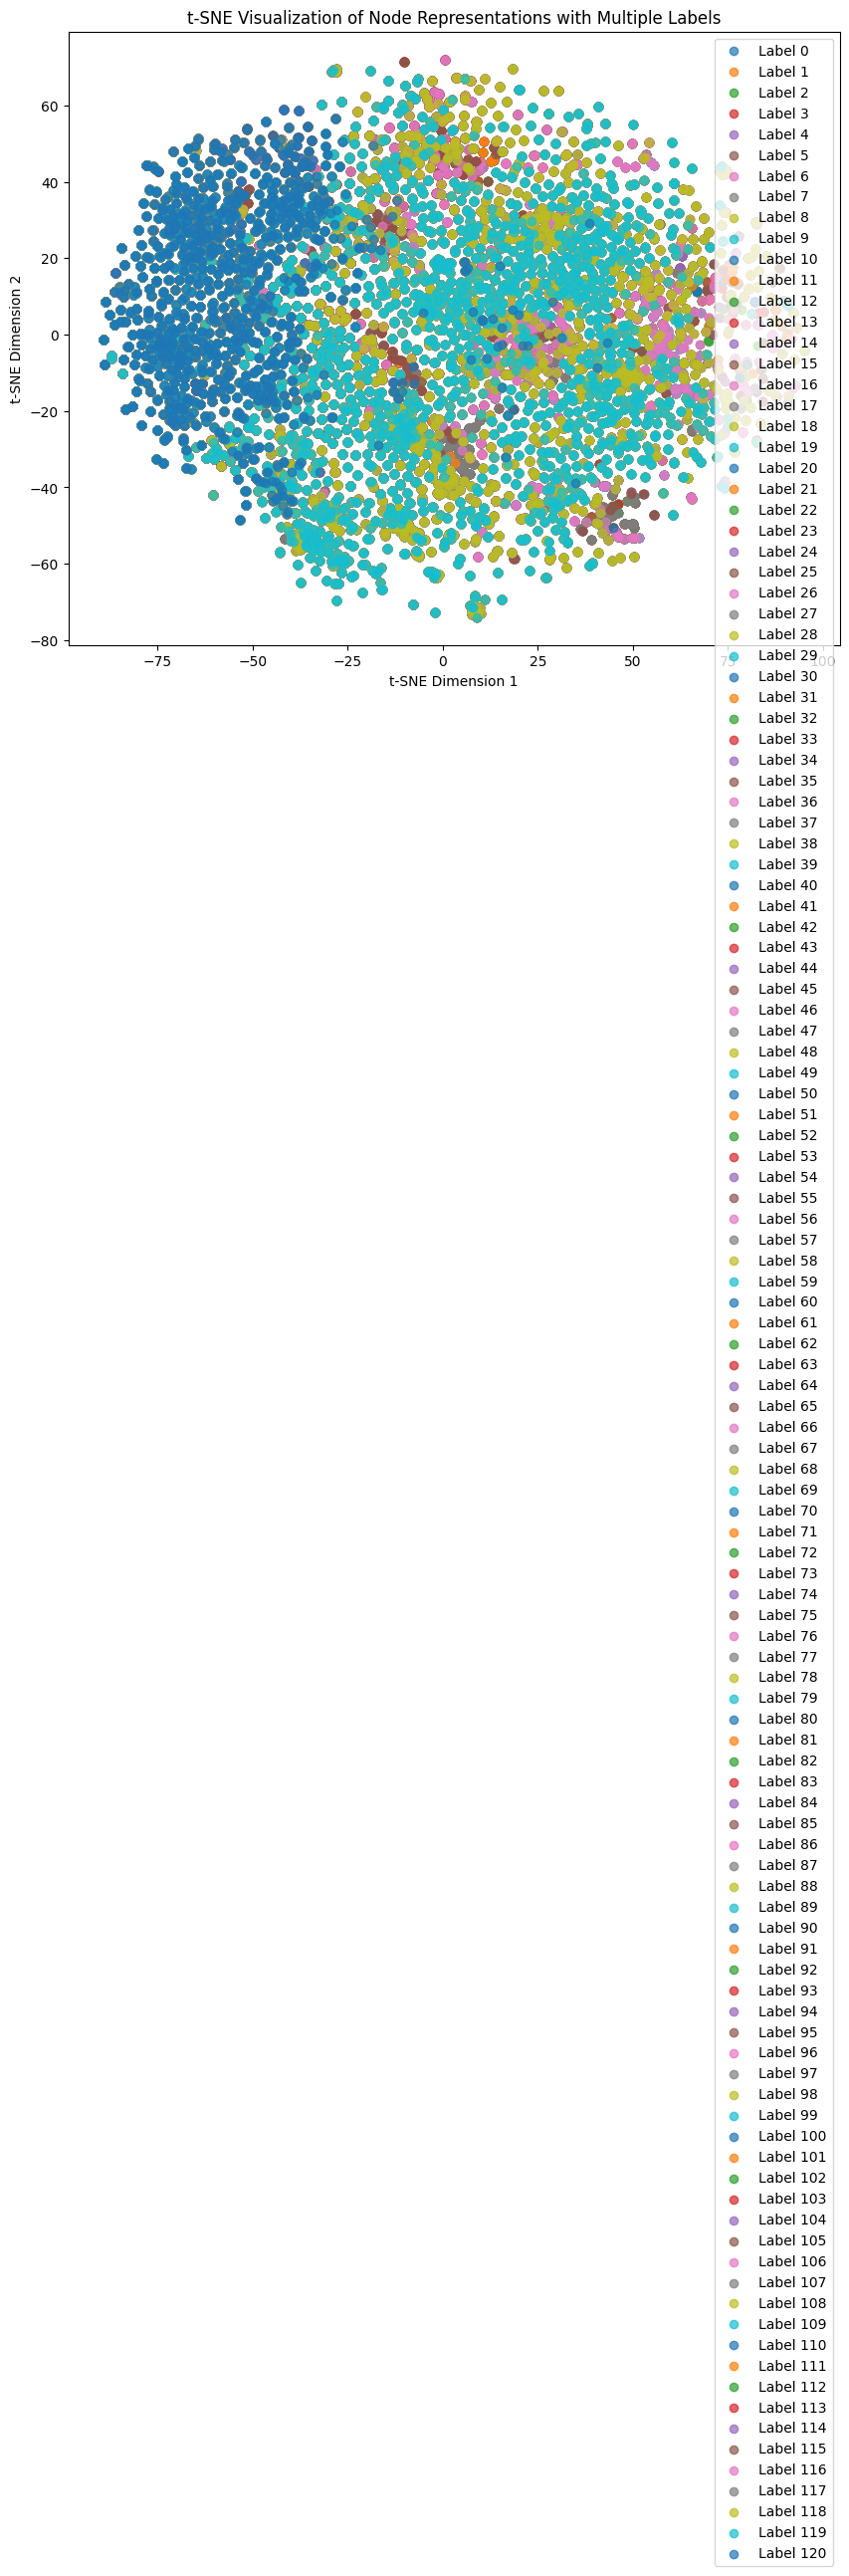

In [38]:
plt.figure(figsize=(10, 8))
for i in range(node_labels.shape[1]):
    plt.scatter(node_embeddings_tsne[node_labels[:, i] == 1, 0],
                node_embeddings_tsne[node_labels[:, i] == 1, 1],
                label=f'Label {i}', alpha=0.7)
plt.title('t-SNE Visualization of Node Representations with Multiple Labels')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.show()